In [1]:
#importing libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
import shapely
from geopandas import GeoDataFrame,GeoSeries
import folium
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import dtale

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from dmba import regressionSummary

In [2]:
final_df = gpd.read_file('final_df.geojson')

In [3]:
final_df.shape

(13979, 26)

In [4]:
final_df[final_df['collisions_count'] > 200].shape

(919, 26)

In [5]:
final_df.collisions_count.describe()

count    13979.000000
mean        49.243365
std         98.401765
min          0.000000
25%          3.000000
50%         12.000000
75%         47.000000
max       1064.000000
Name: collisions_count, dtype: float64

In [6]:
final_df.head(2)

,centreline_id,road_name,road_hierarchy,road_classification,bikelane_present,number_of_lanes,pedestrian_crossover_present,speed_hump_count,traffic_island_count,speed_cushion_count,...,pct_vehicles,pct_pedestrians,pct_cyclists,pct_trucks,traffic_cameras_present,speed_limit,sensitive_zone,collisions_count,ksi_count,geometry
0,914587,Lake Shore Boulevard West,Blvd,Major Arterial,No,2,No,0.0,0.0,0.0,...,90.423881,9.456716,0.119403,1.456716,No,30,Yes,7.0,0.0,"MULTILINESTRING ((-79.51805 43.59795, -79.5191..."
1,914587,Lake Shore Boulevard West,Blvd,Major Arterial,No,2,No,0.0,0.0,0.0,...,90.423881,9.456716,0.119403,1.456716,No,30,Yes,7.0,0.0,"MULTILINESTRING ((-79.51805 43.59795, -79.5191..."


In [7]:
final_df.shape

(13979, 26)

In [8]:
dtale.show(final_df)

d:\Software\Anaconda\lib\site-packages\dtale\views.py:756: FutureWarning:

['geometry'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.



In [9]:
#drop unneccesary columns
final_df = final_df.drop(columns=['road_name','geometry','pct_pedestrians','pct_cyclists','pct_trucks','pct_vehicles','ksi_count'])

In [10]:
#looking at duplicates for centreline id
final_df.centreline_id.duplicated().sum()

5993

In [11]:
#drop duplicate centreline id
final_df = final_df.drop_duplicates(subset='centreline_id', keep='first')

In [12]:
#set centreline id as index
final_df = final_df.set_index('centreline_id')

In [13]:
# feature engineering

#creating column for collision rate by traffic volume * 1000 (1000 road users)
final_df['collision_rate_traffic'] = (final_df['collisions_count'] / (final_df['total_count']))*1000

#creating columns for classification - collisions_count [classes = <5,5-20,20-50,50-80,80-100,>100]
def collision_class(x):
    if x < 5:
        return '<5'
    elif x >= 5 and x < 20:
        return '5-20'
    elif x >= 20 and x < 50:
        return '20-50'
    elif x >= 50 and x < 80:
        return '50-80'
    elif x >= 80 and x < 100:
        return '80-100'
    else:
        return '>100'

final_df['collision_class'] = final_df['collisions_count'].apply(collision_class)

In [14]:
final_df.head()

,road_hierarchy,road_classification,bikelane_present,number_of_lanes,pedestrian_crossover_present,speed_hump_count,traffic_island_count,speed_cushion_count,speed_enforcement_present,cyclists_count,pedestrians_count,total_count,trucks_count,vehicle_count,traffic_cameras_present,speed_limit,sensitive_zone,collisions_count,collision_rate_traffic,collision_class
centreline_id,,,,,,,,,,,,,,,,,,,,
914587,Blvd,Major Arterial,No,2,No,0.0,0.0,0.0,No,10,792,8375,122,7573,No,30,Yes,7.0,0.835821,5-20
6735911,Blvd,Major Arterial,No,2,No,0.0,0.0,0.0,No,10,792,8375,122,7573,No,30,Yes,24.0,2.865672,20-50
914588,St,Local,Yes,2,Yes,0.0,0.0,0.0,No,10,792,8375,122,7573,No,50,Yes,1.0,0.119403,<5
9950476,Blvd,Major Arterial,Yes,2,No,0.0,0.0,0.0,No,13,961,13315,338,12341,No,50,No,76.0,5.707848,50-80
3135620,Line,Major Arterial,No,2,No,0.0,0.0,0.0,No,45,68,12539,549,12426,No,50,Yes,5.0,0.398756,5-20


In [15]:
final_df.collisions_count.describe()

count    7986.000000
mean       43.746932
std        92.159074
min         0.000000
25%         3.000000
50%        10.000000
75%        39.000000
max      1064.000000
Name: collisions_count, dtype: float64

(0.0, 100.0)

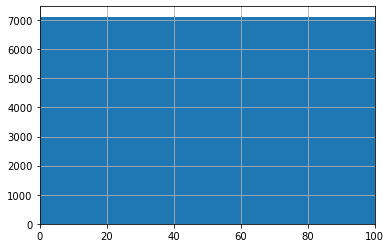

In [16]:
final_df.collisions_count.hist()
plt.xlim(0,100)

In [17]:
dtale.show(final_df)

# Data Exploration

In [18]:
final_df.collisions_count.max()

1064.0

min:0.0, max:1064.0


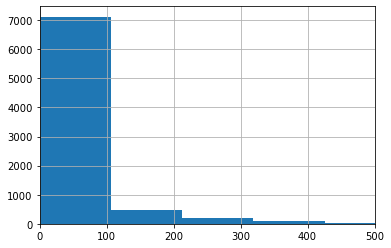

In [19]:
#histogram of target variable - collisions count
final_df.collisions_count.hist()
plt.xlim(0,500)
print(f'min:{final_df.collisions_count.min()}, max:{final_df.collisions_count.max()}')

<AxesSubplot:>

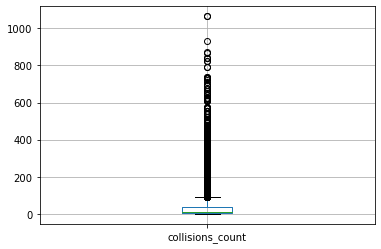

In [20]:
#boxplot of target variable - collisions count
final_df.boxplot(column='collisions_count')

min:0.0, max:383.5294117647059


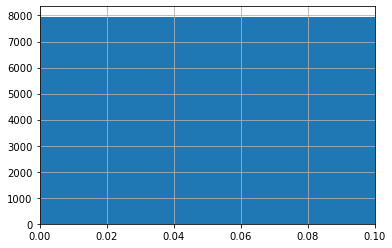

In [21]:
#histogram of target variable - collision rate traffic
final_df.collision_rate_traffic.hist()
plt.xlim(0,0.1)
print(f'min:{final_df.collision_rate_traffic.min()}, max:{final_df.collision_rate_traffic.max()}')

Note: Collision Rate is not as skewed as the total number of collisions

# Data Processing

Processing to do:
- One hot encoding categorical variables
- Principal Component Analysis
- Standardization/Normalization
- Oversampling

Before running the modeling on Python, run it on SAS Enterprise Miner.

<p style='color:red'> Capping Target Variable </p>

In [22]:
#capping target = collisions_count
final_df['collisions_count'] = final_df['collisions_count'].clip(0,500)
#final_df['collisions_count_annual'] = final_df['collisions_count_annual'].clip(0,50)

In [23]:
#instead of capping target = collisions_count try oversampling

<AxesSubplot:xlabel='collisions_count'>

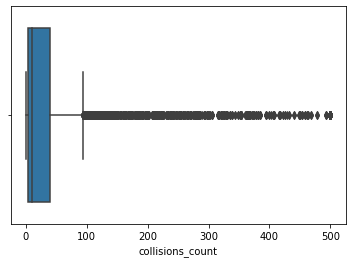

In [24]:
sns.boxplot(data=final_df,x='collisions_count')

<AxesSubplot:>

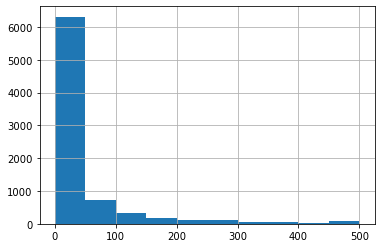

In [25]:
final_df.collisions_count.hist()

In [26]:
final_df.head(2)

,road_hierarchy,road_classification,bikelane_present,number_of_lanes,pedestrian_crossover_present,speed_hump_count,traffic_island_count,speed_cushion_count,speed_enforcement_present,cyclists_count,pedestrians_count,total_count,trucks_count,vehicle_count,traffic_cameras_present,speed_limit,sensitive_zone,collisions_count,collision_rate_traffic,collision_class
centreline_id,,,,,,,,,,,,,,,,,,,,
914587,Blvd,Major Arterial,No,2,No,0.0,0.0,0.0,No,10,792,8375,122,7573,No,30,Yes,7.0,0.835821,5-20
6735911,Blvd,Major Arterial,No,2,No,0.0,0.0,0.0,No,10,792,8375,122,7573,No,30,Yes,24.0,2.865672,20-50


# Modeling Test (Modeling on Untreated Data)

<p style='color:red'>Regression Models can be run on the following variables: collision_count,collision_count_annual,collision_rate_traffic</p>

In [99]:
excluded_columns = ['ksi_count','ksi_rate_traffic','ksi_rate_collisions','pct_vehicles','pct_pedestrians','pct_cyclists','pct_trucks','collisions_count_annual','collisions_count','collisions_injury_fatal','collision_rate_traffic']
outcome = ['collision_class']
predictors = [s for s in final_df.columns if s not in excluded_columns + outcome]

In [100]:
X = pd.get_dummies(final_df[predictors])
y = final_df[outcome]

from sklearn.model_selection import train_test_split
train_X,valid_X,train_y,valid_y = train_test_split(X,y,test_size=0.3,random_state=1)

In [55]:
#instead of capping target = collisions_count try oversampling
#from imblearn.under_sampling import RandomUnderSampler
#ros = RandomUnderSampler(random_state=1)
#train_X_resampled, train_y_resampled = ros.fit_resample(train_X,train_y)

## Test Model 1 - Decision Tree Regressor

In [56]:

test_model = DecisionTreeRegressor(max_depth=8)
test_model.fit(train_X,train_y)

DecisionTreeRegressor(max_depth=8)

In [57]:
regressionSummary(valid_y,test_model.predict(valid_X))


Regression statistics

               Mean Error (ME) : -1.7217
Root Mean Squared Error (RMSE) : 65.8501
     Mean Absolute Error (MAE) : 30.2628


In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
print(f'MSE: {mean_squared_error(valid_y,test_model.predict(valid_X))}')
print(f'MAPE: {mean_absolute_percentage_error(valid_y,test_model.predict(valid_X))}')

MSE: 4336.238000659575
MAPE: 7337425241139091.0


C:\Users\arara\AppData\Local\Temp\ipykernel_41600\2541199208.py:4: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



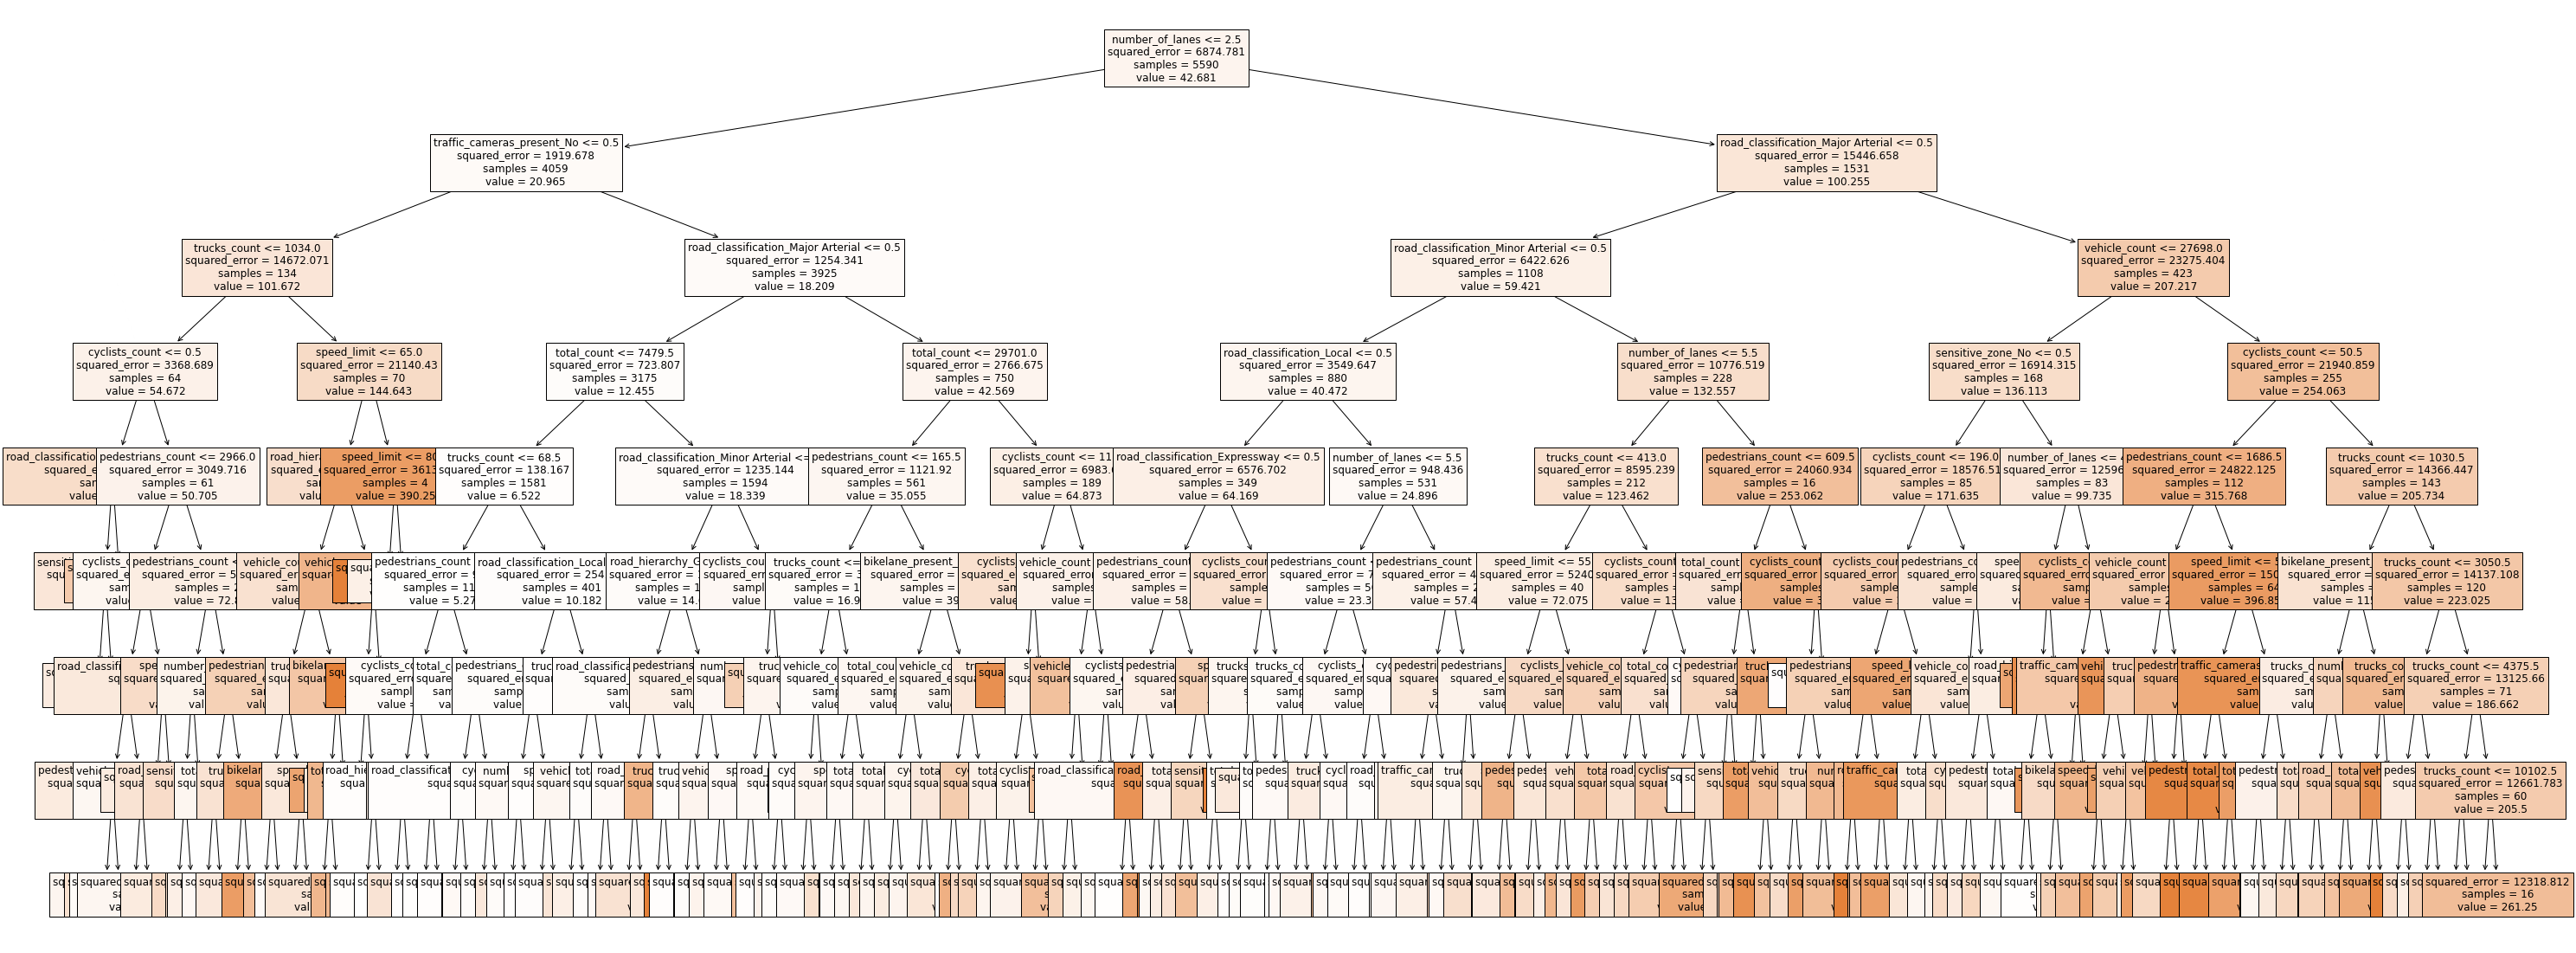

In [58]:
from sklearn.tree import plot_tree
fig,ax = plt.subplots(figsize=(50,20))
plot_tree(test_model,filled=True,fontsize=12,feature_names=train_X.columns)
fig.show()

## Test Model 2 - Random Forest Regressor without Under Sampling

Best model so far.

In [37]:
test_model_2 = RandomForestRegressor()
test_model_2.fit(train_X,train_y)

C:\Users\arara\AppData\Local\Temp\ipykernel_41600\4115193655.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor()

In [38]:
regressionSummary(valid_y,test_model_2.predict(valid_X))


Regression statistics

               Mean Error (ME) : -0.2115
Root Mean Squared Error (RMSE) : 6.2515
     Mean Absolute Error (MAE) : 2.0956


In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
print(f'MSE: {mean_squared_error(valid_y,test_model_2.predict(valid_X))}')
print(f'MAPE: {mean_absolute_percentage_error(valid_y,test_model_2.predict(valid_X))}')

MSE: 39.08145659215001
MAPE: 761103812809638.6


In [ ]:
pd.DataFrame({'coef':test_model_2.feature_importances_,'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)

,coef,predictors
8,3.566821e-01,vehicle_count
6,1.915371e-01,total_count
9,6.000625e-02,speed_limit
5,4.817913e-02,pedestrians_count
4,4.626367e-02,cyclists_count
...,...,...
42,2.812961e-07,road_classification_Collector Ramp
28,1.204819e-07,road_hierarchy_Pk
49,2.162087e-08,road_classification_Minor Arterial Ramp
39,0.000000e+00,road_classification_Access Road


In [ ]:
#looking at residuals for test model 2
residuals_df = pd.DataFrame({'actual':valid_y['collision_rate_traffic'],'predicted':test_model_2.predict(valid_X),'residual':valid_y['collision_rate_traffic']-test_model_2.predict(valid_X)})
residuals_df

,actual,predicted,residual
centreline_id,,,
8313000,0.094625,0.306363,-0.211738
14013581,1.888931,0.337204,1.551726
1145090,0.659964,0.496661,0.163303
439663,5.362762,6.323507,-0.960745
8166223,0.535870,4.598262,-4.062393
...,...,...,...
14037166,2.433006,1.590833,0.842173
444176,0.000000,0.867964,-0.867964
5336642,3.042478,1.791028,1.251450


(-50.0, 50.0)

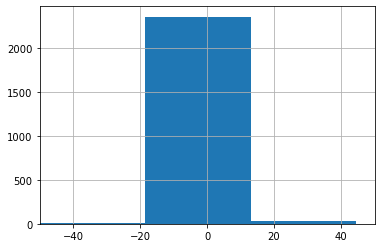

In [ ]:
#histogram of residuals
#residuals seem to be normally distributed
residuals_df.residual.hist()
plt.xlim(-50,50)

In [ ]:
#error statistics on test_model_2
print(mean_squared_error(valid_y['collision_rate_traffic'],test_model_2.predict(valid_X)))
print(r2_score(valid_y['collision_rate_traffic'],test_model_2.predict(valid_X)))

44.38221567648447
-0.20832337182842897


## Test Model 3 - Random Forest Regressor with Undersampling

Undersampling seems to make the models much worse.

In [47]:
#training random forest model on undersampled data
test_model_3 = RandomForestRegressor()
test_model_3.fit(train_X_resampled,train_y_resampled)

NameError: name 'train_X_resampled' is not defined

In [ ]:
regressionSummary(valid_y,test_model_3.predict(valid_X))


Regression statistics

               Mean Error (ME) : -81.5581
Root Mean Squared Error (RMSE) : 125.4476
     Mean Absolute Error (MAE) : 92.5328


In [ ]:
#looking at residuals for test model 2
residuals_df_3 = pd.DataFrame({'actual':valid_y['collisions_count'],'predicted':test_model_3.predict(valid_X),'residual':valid_y['collisions_count']-test_model_3.predict(valid_X)})
residuals_df

,actual,predicted,residual
centreline_id,,,
20234754,0.0,0.310000,-0.310000
8681183,276.0,63.375000,212.625000
9544878,13.0,13.339167,-0.339167
8566053,52.0,30.274000,21.726000
30018282,146.0,142.670000,3.330000
...,...,...,...
908817,67.0,40.750000,26.250000
6942841,3.0,20.136619,-17.136619
9096,39.0,29.282000,9.718000


<AxesSubplot:>

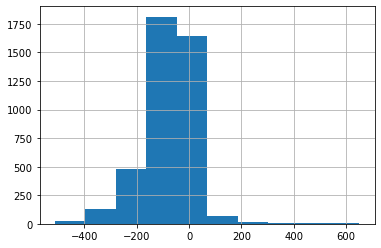

In [ ]:
#histogram of residuals
#residuals seem to be normally distributed
residuals_df_3.residual.hist()

In [ ]:
x = pd.DataFrame({'coef':test_model_3.feature_importances_,'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)

In [ ]:
#error statistics on test_model_3
print(mean_squared_error(valid_y['collisions_count'],test_model_3.predict(valid_X)))
print(r2_score(valid_y['collisions_count'],test_model_3.predict(valid_X)))

15737.104400309967
-0.6018158785923533


## Test Model 4 - Linear Regression without Under Sampling

In [41]:
from sklearn.linear_model import LinearRegression
test_model_4 = LinearRegression()
test_model_4.fit(train_X,train_y)

LinearRegression()

In [44]:
regressionSummary(valid_y,test_model_4.predict(valid_X))


Regression statistics

               Mean Error (ME) : -0.2446
Root Mean Squared Error (RMSE) : 5.9558
     Mean Absolute Error (MAE) : 2.6822


In [45]:
print(f'MSE: {mean_squared_error(valid_y,test_model_4.predict(valid_X))}')
print(f'MAPE: {mean_absolute_percentage_error(valid_y,test_model_4.predict(valid_X))}')

MSE: 35.471092404123205
MAPE: 717088404533764.0


In [ ]:
test_model_4_coef = pd.DataFrame(test_model_4.coef_).transpose()
test_model_4_coef

,0
0,17.158580
1,-0.148735
2,55.645479
3,0.427494
4,0.266816
...,...
56,-8.230762
57,-38.823360
58,38.823360
59,-9.295956


In [ ]:
linear_model_4_coef = pd.DataFrame({'coef':test_model_4_coef[0],'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)
linear_model_4_coef.head(10)

,coef,predictors
20,66.925908,road_hierarchy_Gt
40,61.799498,road_classification_Busway
2,55.645479,traffic_island_count
43,54.988505,road_classification_Expressway
46,47.855173,road_classification_Major Arterial
31,41.913683,road_hierarchy_Ramp
58,38.823360,traffic_cameras_present_Yes
48,23.945287,road_classification_Minor Arterial
27,22.954382,road_hierarchy_Path
16,20.896791,road_hierarchy_Crt


## Test Model 5 - Random Forest Classifier

In [47]:
excluded_columns = ['ksi_count','ksi_rate_traffic','ksi_rate_collisions','pct_vehicles','pct_pedestrians','pct_cyclists','pct_trucks','collision_rate_traffic','collisions_count_annual','collision_class','collisions_count','total_count']
outcome = ['collision_class']
predictors = [s for s in final_df.columns if s not in excluded_columns + outcome]

X = pd.get_dummies(final_df[predictors])
y = final_df[outcome]

from sklearn.model_selection import train_test_split
train_X,valid_X,train_y,valid_y = train_test_split(X,y,test_size=0.3,random_state=1)

In [48]:
from sklearn.ensemble import RandomForestClassifier
test_model_5 = RandomForestClassifier(random_state=1)
test_model_5.fit(train_X,train_y)

C:\Users\arara\AppData\Local\Temp\ipykernel_58296\1230521718.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(random_state=1)

In [49]:
from dmba import classificationSummary
classificationSummary(valid_y,test_model_5.predict(valid_X),class_names=['<5','5-20','20-50','50-80','80-100','>100'])

Confusion Matrix (Accuracy 0.5146)

       Prediction
Actual     <5   5-20  20-50  50-80 80-100   >100
    <5    132    165     30      1     42     29
  5-20     86    331      9      2    245     20
 20-50     43     42     17      2     18     28
 50-80     10     16      6      4      6     25
80-100     42    186      1      2    561     20
  >100     28     28     14      3     14    188


In [50]:
pd.DataFrame({'coef':test_model_5.feature_importances_,'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False).head()

,coef,predictors
7,0.147233,vehicle_count
6,0.145986,trucks_count
5,0.143488,pedestrians_count
4,0.124267,cyclists_count
0,0.084722,number_of_lanes


## Test Model 6 - Random Forest Classifier with Under Sampling

In [51]:
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=1)
train_X_resampled, train_y_resampled = ros.fit_resample(train_X,train_y)

In [52]:
from sklearn.ensemble import RandomForestClassifier
test_model_6 = RandomForestClassifier(random_state=1)
test_model_6.fit(train_X_resampled,train_y_resampled)

C:\Users\arara\AppData\Local\Temp\ipykernel_58296\1110826313.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(random_state=1)

In [53]:
classificationSummary(valid_y,test_model_6.predict(valid_X),class_names=['<5','5-20','20-50','50-80','80-100','>100'])

Confusion Matrix (Accuracy 0.4370)

       Prediction
Actual     <5   5-20  20-50  50-80 80-100   >100
    <5    134     48     86     59     36     36
  5-20    138    206     76     37    210     26
 20-50     36      9     57     19     11     18
 50-80      7      3     14     19      3     21
80-100     72    172     32     37    467     32
  >100     28      7     28     44      4    164


In [54]:
pd.DataFrame({'coef':test_model_6.feature_importances_,'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False).head()

,coef,predictors
5,0.142179,pedestrians_count
7,0.139517,vehicle_count
6,0.135455,trucks_count
4,0.114859,cyclists_count
0,0.077380,number_of_lanes


<p style='color:red'>Note: An accuracy of 0.56 doesn't mean 0.6 better than random, because random guess with 6 class targets is 17% accuracy (100/6). So the model is actually 0.39 or 39% better than a random guess.</p> 